In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from IPython.display import HTML

import sys
sys.path.append("..")

import omeka_tools.utils as ou

%load_ext autoreload
%autoreload 2

In [10]:
from pathlib import Path
filepath_metadata = Path("./data/metadata_df.csv")

metadata_df = pd.read_csv(filepath_metadata)

### Metadata Types

`Existing Metadata`

In [11]:
metadata_df['element_set__name'].unique()

array(['Item Type Metadata', 'Dublin Core'], dtype=object)

In [12]:
metadata_df.groupby('element_set__name')['element__name'].nunique()

element_set__name
Dublin Core           15
Item Type Metadata    75
Name: element__name, dtype: int64

There are two main types of metadata, default categories from Dublin Core (N=15), and additional custom categories from Item Type Metadata (N=75)

In [13]:
metadata_df[metadata_df['element_set__name'] == 'Dublin Core']['element__name'].unique()

array(['Title', 'Creator', 'Access Rights', 'Type', 'Language',
       'Identifier', 'Rights Holder', 'Source', 'License', 'Rights',
       'Date Available', 'Contributor', 'Date Valid', 'Description',
       'Medium'], dtype=object)

In [14]:
metadata_df[metadata_df['element_set__name'] == 'Item Type Metadata']['element__name'].unique()

array(['FormerDB-ID', 'Translated Title (German)',
       'Translated Title (English)',
       'Translated Full Text Fragment (German)',
       'Translated Full Text Fragment (English)',
       'Made Available For Insertion', 'Metadata Author',
       'Translated Title (Dutch)',
       'Translated Full Text Fragment (Dutch)', 'Display Label (English)',
       'Display label (German)', 'Display Label (Dutch)', 'Zoom  Level',
       'Viewpoint Latitude', 'Viewpoint Longitude', 'Viewpoint Elevation',
       'View Pitch', 'View Yaw', 'View Roll', 'Label Latitude',
       'Label Longitude', 'Reference Place Elevation',
       'Main Caption (English)', 'Main Caption (German)',
       'Main Caption (Dutch)', 'FormerDB-Filename', 'Source Reference',
       'Dates of Creation', 'Dates of Reference', 'Origin Place Latitude',
       'Origin Place Longitude', 'Reference Place Latitude',
       'Reference Place Longitude', 'Additional Caption 1 (English)',
       'Additional Caption 1 (German)', 'O

### Metadata Usage

`metadata usage`

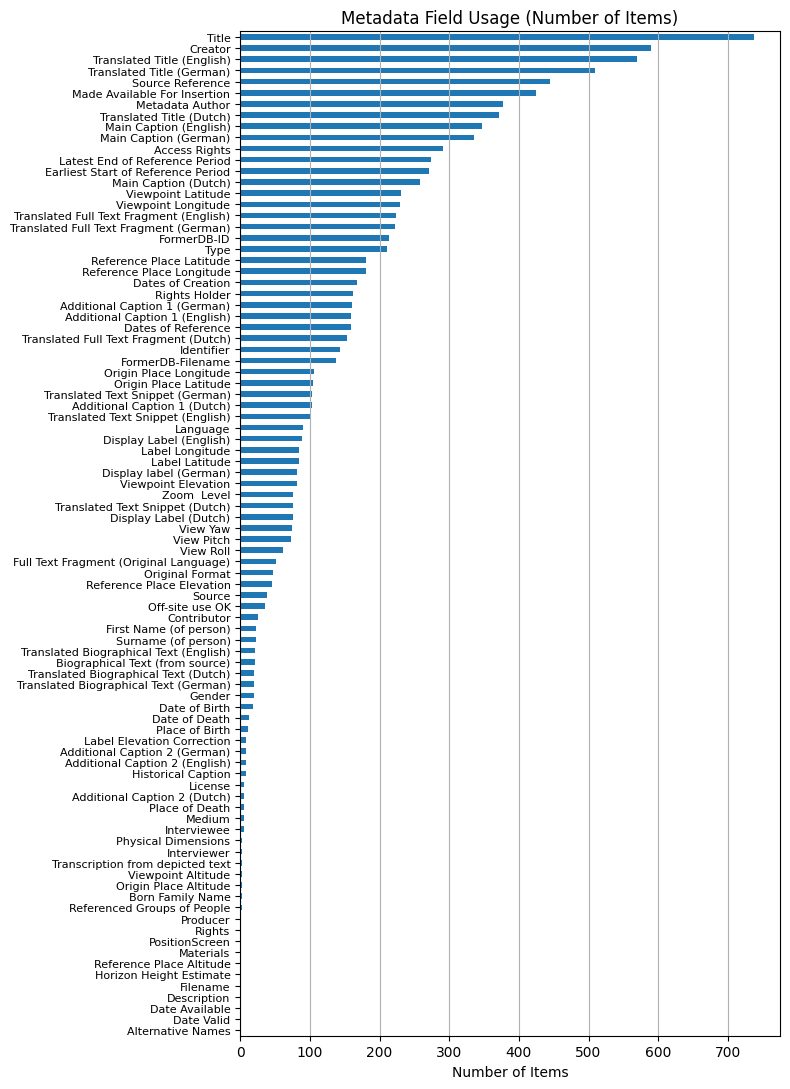

In [15]:
# Group by element name and count unique item IDs
grouped = metadata_df.groupby('element__name')['id'].nunique().sort_values(ascending=True)

# Create bar plot
plt.figure(figsize=(8, 11))
grouped.plot(kind='barh')
plt.title('Metadata Field Usage (Number of Items)')
plt.xlabel('Number of Items')
plt.ylabel('')
# plt.xticks(rotation=90)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.grid(axis='x')
plt.show()

html table format

In [109]:
grouped = metadata_df.groupby('element__name')['id'].nunique().sort_values(ascending=False)

grouped_df = grouped.reset_index()
grouped_df.columns = ['Metadata Field', 'Number of Items']

# Convert to HTML table
html_table = grouped_df.to_html(index=False)

# Display HTML table in notebook
HTML(html_table)

Metadata Field,Number of Items
Title,738
Creator,589
Translated Title (English),569
Translated Title (German),510
Source Reference,445
Made Available For Insertion,424
Metadata Author,377
Translated Title (Dutch),371
Main Caption (English),347
Main Caption (German),336


`metadata usage` per item_type__name

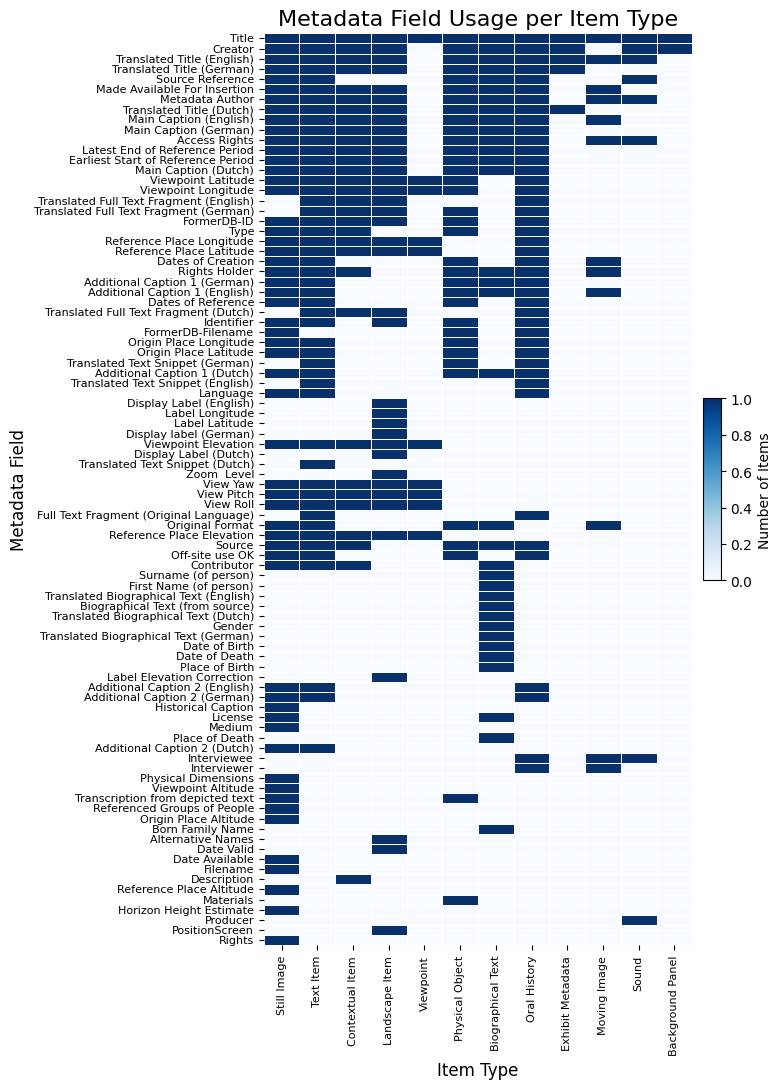

In [103]:
grouped_item_type = metadata_df.groupby(['item_type__name', 'element__name'])['id'].nunique()

# Step 1: Convert to wide format (item_type as rows, element__name as columns)
heatmap_df = grouped_item_type.unstack(fill_value=0).T

# Step 2: Sort rows and columns by total count
sorted_rows = heatmap_df.sum(axis=1).sort_values(ascending=False).index  # metadata fields
sorted_cols = heatmap_df.sum(axis=0).sort_values(ascending=False).index  # item types

heatmap_df = heatmap_df.loc[sorted_rows, sorted_cols]

# Step 3: Plot heatmap
# Create plot with custom figure and axes
fig, ax = plt.subplots(figsize=(8, 11))

# Create heatmap
sns_heatmap = sns.heatmap(
    heatmap_df,
    cmap='Blues',
    linewidths=0.5,
    ax=ax,
    cbar=False,
    vmin=0,
    vmax=1
)

# Manually add smaller colorbar
cbar = ax.figure.colorbar(sns_heatmap.collections[0], ax=ax, shrink=0.2, aspect=10, pad=0.02)
cbar.set_label("Number of Items", fontsize=10)

# Labels and ticks
ax.set_title('Metadata Field Usage per Item Type', fontsize=16)
ax.set_xlabel('Item Type', fontsize=12)
ax.set_ylabel('Metadata Field', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

# Force all y-ticks to show
ax.set_yticks(np.arange(0.5,len(heatmap_df.index)+0.5))
ax.set_yticklabels(heatmap_df.index)

plt.tight_layout()
plt.show()

### Metadata Categorization

In [65]:
metadata_categories = ou.load_yaml('../metadata_categories.yaml')
categories_metadata = ou.reverse_yaml(metadata_categories)

Apply metadata categorization

In [66]:
metadata_df["element__category"] = metadata_df["element__name"].map(categories_metadata)

Visualize categories usage

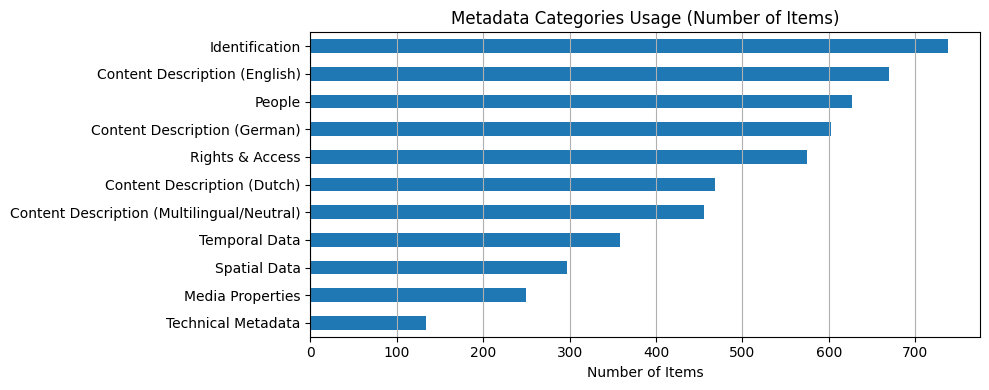

In [67]:
grouped_categories = metadata_df.groupby("element__category")['id'].nunique().sort_values(ascending=True)

# Create bar plot
plt.figure(figsize=(10, 4))
grouped_categories.plot(kind='barh')
plt.title('Metadata Categories Usage (Number of Items)')
plt.xlabel('Number of Items')
plt.ylabel('')
# plt.xticks(rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(axis='x')
plt.show()

### Metadata Checks

#### Repeated Metadata

I have observed that often 'Title' from Dublin Core and 'Translated Title (English)' are repeated, let's check if they always are and in which cases not

In [68]:
# Create a wide-form table showing which element names appear per item
title_check = metadata_df.pivot_table(
    index="id",  # or use "item_id" if available
    columns="element__name",
    values="text",  # or another column, e.g., "element__id"
    aggfunc="first"
)

# Check presence of both fields
has_title = title_check["Title"].notna()
has_translated_title = title_check["Translated Title (English)"].notna()

# Compare
both_present = has_title & has_translated_title
only_title = has_title & ~has_translated_title
only_translated_title = ~has_title & has_translated_title
neither = ~has_title & ~has_translated_title

# Summary
print("Both present:", both_present.sum())
print("Only Title:", only_title.sum())
print("Only Translated Title (English):", only_translated_title.sum())
print("Neither:", neither.sum())

# Optionally, list the item IDs missing one or both
missing_df = title_check[only_title | only_translated_title | neither]


Both present: 567
Only Title: 171
Only Translated Title (English): 2
Neither: 0


Examine rows content

In [69]:
# 1. Items with both
print("Items with both Title and Translated Title (English):")
display(title_check[has_title & has_translated_title][["Title", "Translated Title (English)"]])

# 2. Items with only Title
print("Items with only Title:")
display(title_check[has_title & ~has_translated_title][["Title", "Translated Title (English)"]])

# 3. Items with only Translated Title (English)
print("Items with only Translated Title (English):")
display(title_check[~has_title & has_translated_title][["Title", "Translated Title (English)"]])

# 4. Items with neither
print("Items with neither Title nor Translated Title (English):")
display(title_check[~has_title & ~has_translated_title][["Title", "Translated Title (English)"]])


Items with both Title and Translated Title (English):


element__name,Title,Translated Title (English)
id,,
839,Hut 211,Hut 211
840,Huts 9 and 10,Huts 9 and 10
841,The Men's Camp,The Men's Camp
842,The Star Camp,The Star Camp
843,The Gate to the Concentration Camp Prisoners'...,The Gate to the Concentration Camp Prisoners'...
...,...,...
2151,BBMemo2024 Aimé Blanc's prisoner tag,Aimé Blanc's prisoner tag
2152,BBMemo2024 Status report for Bergen-Belsen con...,Status report for Bergen-Belsen concentration ...
2153,BBMemo2024 Bibel und Predigtskizze,Bible and sermon sketch


Items with only Title:


element__name,Title,Translated Title (English)
id,,
860,VP M.B. 87 Nebenlager,NaN
1333,(Hohne test item) BU 6591,NaN
1516,item video prueba,NaN
1518,item text item prueba,NaN
1519,Sound item prueba,NaN
...,...,...
2101,BBMemo2024 Latrine Huts,NaN
2103,BBMemo2024 LND Main street,NaN
2105,BBMemo2024 LND The camp's perimeter and watcht...,NaN


Items with only Translated Title (English):


element__name,Title,Translated Title (English)
id,,
1453,NaN,placeholder English
1454,NaN,placeholder English


Items with neither Title nor Translated Title (English):


element__name,Title,Translated Title (English)
id,,


We observe that several test items are included in the non repeated group as well as titles in other languages.

To clean up the repository:

- **Test items should be removed**
- **Metadata edited to ensure consistency in usage**

---

For next analysis on NER and Linking with KG, we will obviate the cases where title and translated title are not redundant

In [70]:
subset = list(title_check[has_title & has_translated_title].index)

metadata = metadata_df.set_index('id')
metadata = metadata.loc[subset]

In [71]:
metadata.to_csv('../data/metadata_subset_df.csv')